#### Author: Michael Polinsky

In [476]:
import pandas as pd
import numpy as np
import seaborn as sbn
import matplotlib
import matplotlib.pyplot as plt
import scipy as sp

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, classification_report, plot_roc_curve, roc_curve

# Import data

In [477]:
d = pd.read_csv('heart.csv')

## Examine data: some of these are categorical and some are raw values.  

In [478]:
d.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


### Non-null count equals total number of lines, suggests no nulls in the dataset.

In [479]:
d.info() # Suggests zero non-null but will have to look more closely for missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


## Taking a look at the distributions of the data.  The scales range from tenths to hundreds.

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'sex'}>,
        <AxesSubplot:title={'center':'cp'}>,
        <AxesSubplot:title={'center':'trestbps'}>],
       [<AxesSubplot:title={'center':'chol'}>,
        <AxesSubplot:title={'center':'fbs'}>,
        <AxesSubplot:title={'center':'restecg'}>,
        <AxesSubplot:title={'center':'thalach'}>],
       [<AxesSubplot:title={'center':'exang'}>,
        <AxesSubplot:title={'center':'oldpeak'}>,
        <AxesSubplot:title={'center':'slope'}>,
        <AxesSubplot:title={'center':'ca'}>],
       [<AxesSubplot:title={'center':'thal'}>,
        <AxesSubplot:title={'center':'target'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

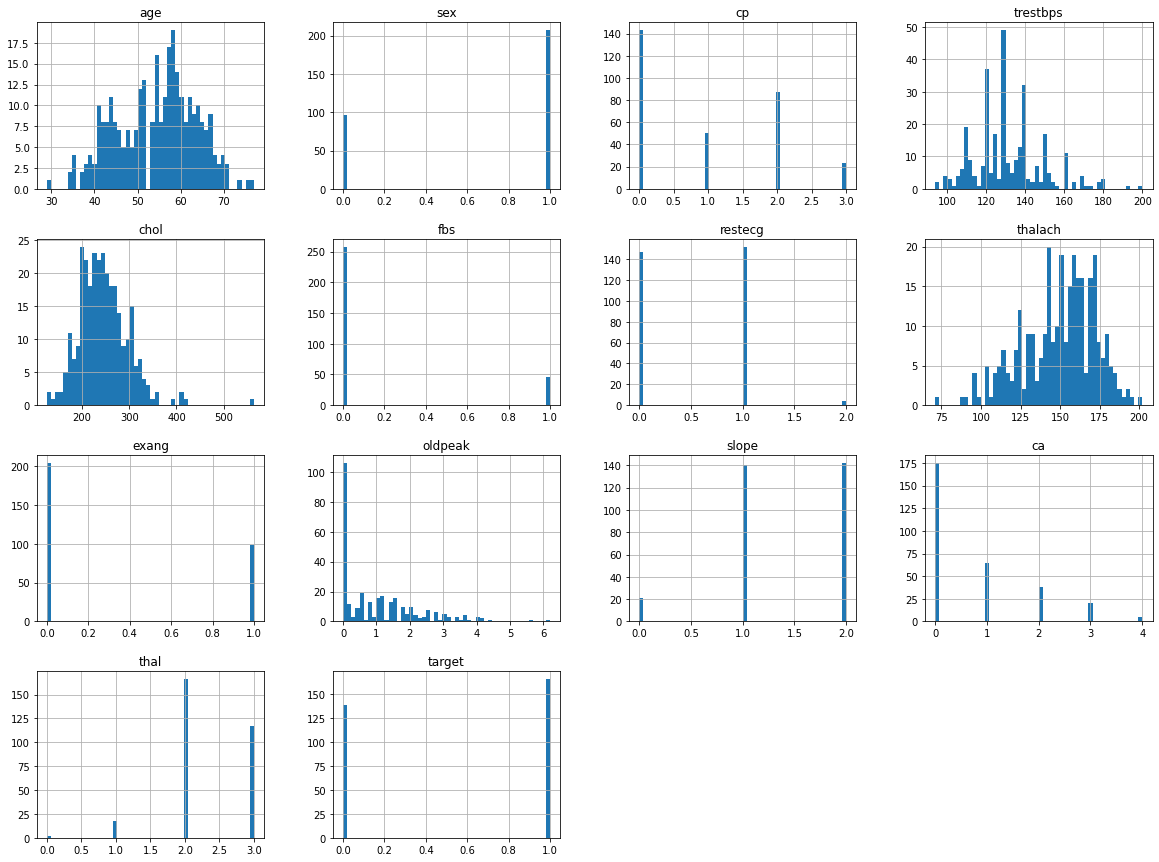

In [480]:
d.hist(bins=50, figsize=(20,15))

In [481]:
d.nunique()

age          41
sex           2
cp            4
trestbps     49
chol        152
fbs           2
restecg       3
thalach      91
exang         2
oldpeak      40
slope         3
ca            5
thal          4
target        2
dtype: int64

# 1. Plot distribution of age and sex for each target class.

### Age:

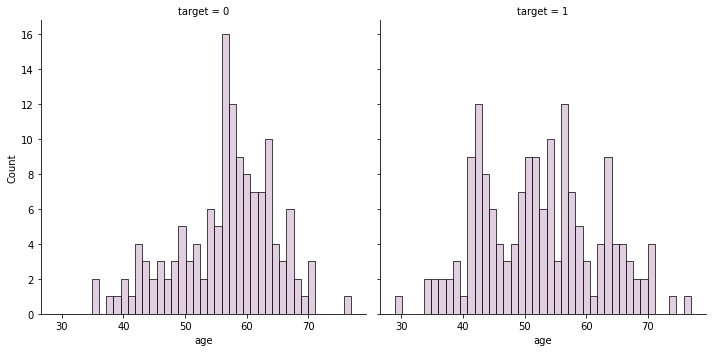

In [482]:
sbn.displot(d, x='age', col='target', bins=41, color='thistle') #element='step' kind='kde',

### Sex:

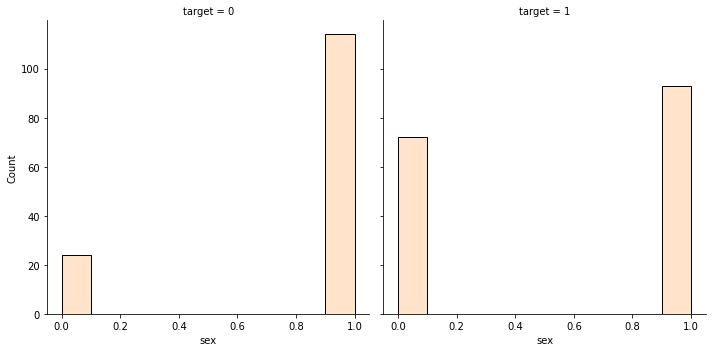

In [483]:
sbn.displot(d, x='sex', col='target', color='peachpuff') #element='step'

# 2. Plot correlation values for all features with respect to the target class.

### Using .corr()  to calculate Pearson's r for the whole dataset

In [484]:
correlations = d.corr()

In [485]:
target_corr = pd.DataFrame(correlations['target'])

## Plotting the 'target' column of the correlation heatmap.
### Shows the correlation of each feature with the target

<AxesSubplot:>

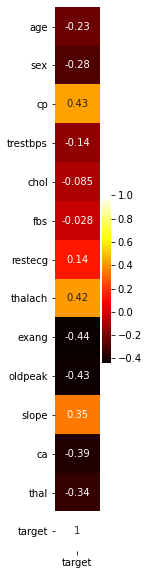

In [486]:
plt.figure(figsize=(1,10)) 
sbn.heatmap(target_corr, cmap='hot', annot=True)

### I see the strongest correlations being -0.44, -0.43, -0.39, and +0.43, corresponding to 'exang', 'oldpeak', 'ca', and 'cp'.  
### Nothing greater than .50.

# 3. Check for any missing feature values and impute as necessary.

### I have found none.  Though I found a suggestion online that there are about 5 missing values in 2 columns.

In [487]:
d.loc[:, d.isnull().any()].columns

Index([], dtype='object')

In [488]:
np.isnan(d).any() 

age         False
sex         False
cp          False
trestbps    False
chol        False
fbs         False
restecg     False
thalach     False
exang       False
oldpeak     False
slope       False
ca          False
thal        False
target      False
dtype: bool

In [489]:
d.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [490]:
d.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

# 4. Use an 80-20 split to train LR, RF, and SGD classifiers.

### Split off target from input features

In [491]:
X = d.drop(columns='target')#.values.reshape(-1,1)
Y = d.loc[:,'target']#.values.reshape(-1,1)

### Shape dataset columns

In [492]:
for col, item in X.iteritems():
    item = item.values.reshape(-1,1)

### Split

In [493]:
trainX, testX, trainY, testY = train_test_split(X, Y, train_size = 0.80, 
                                                      test_size = 0.20,
                                                      random_state = 11)

### Look at the sized of the splits: 242-61.  These are small datasets!

In [494]:
trainX.shape

(242, 13)

In [495]:
testX.shape

(61, 13)

## Create a scaled copy of the input data.   

In [496]:
ss = StandardScaler()
SGDX = ss.fit_transform(trainX)
SGDX_t = ss.transform(testX)

# Train LR model

In [497]:
lr = LogisticRegression(fit_intercept=True,
                        multi_class='auto',
                        penalty='l1', #lasso regression
                        solver='saga', 
                        max_iter=1000, # <--- Hp
                        C=50,  
                        verbose=2, # output progress
                        n_jobs=5, # parallelize over 5 processes <--- Needed? 
                        tol=0.01  #  <--- what is this?
                         ) # radnom state?
lr_classifier = lr.fit(trainX, trainY)
lr_c_2 = lr.fit(SGDX, trainY)

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished


convergence after 22 epochs took 0 seconds
convergence after 8 epochs took 0 seconds


## Test using crossval score

In [498]:
# Score using 5-fold cv on classifier trained on unscaled data
score1 = cross_val_score(lr_classifier, trainX, trainY, cv=5, scoring='accuracy')
score2 = cross_val_score(lr_classifier, testX, testY, cv=5, scoring='accuracy')

# Score using 5-fold cv on classifier trained on scaled data
score1b = cross_val_score(lr_c_2, SGDX, trainY, cv=5, scoring='accuracy', verbose=0)
score2b = cross_val_score(lr_c_2, SGDX_t, testY, cv=5, scoring='accuracy', verbose=0)

# Collect means of cv accuracy scores for display
lr_means = []
lr_means.append(np.mean(score1))
lr_means.append(np.mean(score2))
lr_means.append(np.mean(score1b))
lr_means.append(np.mean(score2b))

# Create dataFrames to display scores
lr_mean = pd.DataFrame({ 'Training mean' : [lr_means[0]] , 'Test mean' : [lr_means[1]], 'Training mean (scaled)' : [lr_means[2]] , 'Test mean (scaled)' : [lr_means[3]]})
lr_scores = pd.DataFrame({ 'Training score' : score1 , 'Test score' : score2, 'Training score (scaled)' : score1b , 'Test score (scaled)' : score2b})

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   

### Display Training/Test Scores and averages

In [499]:
lr_scores

,Training score,Test score,Training score (scaled),Test score (scaled)
0,0.734694,0.307692,0.836735,0.692308
1,0.775510,0.666667,0.816327,0.916667
2,0.708333,0.833333,0.791667,0.916667
3,0.541667,0.666667,0.875000,0.583333
4,0.729167,0.750000,0.875000,0.750000


In [500]:
lr_mean

,Training mean,Test mean,Training mean (scaled),Test mean (scaled)
0,0.697874,0.644872,0.838946,0.771795


# Confusion matrix and ROC curve

In [501]:
# Get predictions using cross_val_predict
lr_prd = cross_val_predict(lr_classifier, testX, testY, cv=10)
lr_pred2 = cross_val_predict(lr_c_2, SGDX_t, testY, cv=10)
labels = lr_classifier.classes_

# compute TP, TN, FP, FN values for each classifier
lr_cm = confusion_matrix(y_true=testY, y_pred = lr_prd, labels = labels)
lr2_cm = confusion_matrix(y_true=testY, y_pred = lr_pred2, labels = labels)
# compute recall, precision, f1-scores for each classifier
lr_cr = classification_report(y_true=testY, y_pred = lr_prd, labels = labels)
lr2_cr = classification_report(y_true=testY, y_pred = lr_pred2, labels = labels)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 out of   1 | elapsed:   

#### Confusion matrix for classifier trained on unscaled data

In [502]:
pd.DataFrame(lr_cm, index=labels, columns=labels)

,0,1
0,8,16
1,7,30


#### Classification report for classifier trained on unscaled data

In [503]:
print(lr_cr)

              precision    recall  f1-score   support

           0       0.53      0.33      0.41        24
           1       0.65      0.81      0.72        37

    accuracy                           0.62        61
   macro avg       0.59      0.57      0.57        61
weighted avg       0.61      0.62      0.60        61



#### Confusion matrix for classifier trained on scaled data

In [504]:
pd.DataFrame(lr2_cm, index=labels, columns=labels)

,0,1
0,15,9
1,7,30


#### Classification report for classifier trained on scaled data

In [505]:
print(lr2_cr)

              precision    recall  f1-score   support

           0       0.68      0.62      0.65        24
           1       0.77      0.81      0.79        37

    accuracy                           0.74        61
   macro avg       0.73      0.72      0.72        61
weighted avg       0.73      0.74      0.74        61



### ROC curve for training set

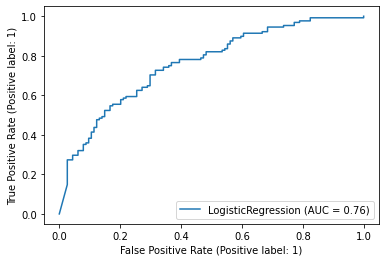

In [506]:
lr_classifier_disp = plot_roc_curve(lr_classifier, trainX, trainY)
plt.show()

### ROC curve for test set

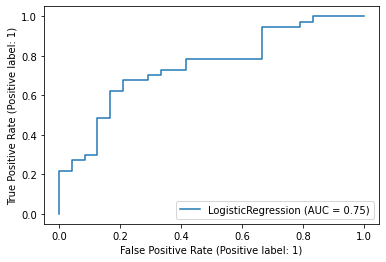

In [507]:
lr_classifier_disp = plot_roc_curve(lr_classifier, testX, testY)
plt.show()

# Train Random Forest

In [508]:
rf_classifier = RandomForestClassifier(n_estimators=100, n_jobs=5)
rf_c =  rf_classifier.fit(trainX, trainY) # unscaled
rf_c_2 = rf_classifier.fit(SGDX, trainY)  # scaled

## Test using crossval score and maybe still round or present as percent

In [509]:
# Score using 5-fold cv on classifier trained on unscaled data
score3 = cross_val_score(rf_c, trainX, trainY, cv=5, scoring='accuracy')
score4 = cross_val_score(rf_c, testX, testY, cv=5, scoring='accuracy')

# Score using 5-fold cv on classifier trained on scaled data
score3b = cross_val_score(rf_c_2, SGDX, trainY, cv=5, scoring='accuracy')
score4b = cross_val_score(rf_c_2, SGDX_t, testY, cv=5, scoring='accuracy')

# Collect means of cv accuracy scores for display
rf_means = []
rf_means.append(np.mean(score3))
rf_means.append(np.mean(score4))
rf_means.append(np.mean(score3b))
rf_means.append(np.mean(score4b))

# Create dataFrames to display scores
rf_mean = pd.DataFrame({ 'Training mean' : [rf_means[0]] , 'Test mean' : [rf_means[1]], 'Training mean (scaled)' : [rf_means[2]] , 'Test mean (scaled)' : [rf_means[3]]})
rf_scores = pd.DataFrame({ 'Training score' : score3 , 'Test score' : score4, 'Training score (scaled)' : score3b , 'Test score (scaled)' : score4b})

In [510]:
rf_scores

,Training score,Test score,Training score (scaled),Test score (scaled)
0,0.857143,0.769231,0.816327,0.769231
1,0.836735,0.916667,0.836735,0.916667
2,0.812500,1.000000,0.812500,0.916667
3,0.854167,0.583333,0.791667,0.666667
4,0.812500,0.833333,0.895833,0.750000


In [511]:
rf_mean

,Training mean,Test mean,Training mean (scaled),Test mean (scaled)
0,0.834609,0.820513,0.830612,0.803846


# Confusion matrix and ROC curve

In [512]:
# Get predictions using cross_val_predict
rf_prd = cross_val_predict(rf_c, testX, testY, cv=10)
rf_pred2 = cross_val_predict(rf_c_2, SGDX_t, testY, cv=10)
labels = rf_classifier.classes_

# compute TP, TN, FP, FN values for each classifier
rf_cm = confusion_matrix(y_true=testY, y_pred = rf_prd, labels = labels)
rf2_cm = confusion_matrix(y_true=testY, y_pred = rf_pred2, labels = labels)

# compute recall, precision, f1-scores for each classifier
rf_cr = classification_report(y_true=testY, y_pred = rf_prd, labels = labels)
rf2_cr = classification_report(y_true=testY, y_pred = rf_pred2, labels = labels)

#### Confusion matrix for classifier trained on unscaled data

In [513]:
pd.DataFrame(rf_cm, index=labels, columns=labels)

,0,1
0,18,6
1,4,33


#### Classification report for classifier trained on unscaled data

In [514]:
print(rf_cr)

              precision    recall  f1-score   support

           0       0.82      0.75      0.78        24
           1       0.85      0.89      0.87        37

    accuracy                           0.84        61
   macro avg       0.83      0.82      0.83        61
weighted avg       0.84      0.84      0.83        61



#### Confusion matrix for classifier trained on scaled data

In [515]:
pd.DataFrame(rf2_cm, index=labels, columns=labels)

,0,1
0,18,6
1,4,33


#### Classification report for classifier trained on scaled data

In [516]:
print(rf2_cr)

              precision    recall  f1-score   support

           0       0.82      0.75      0.78        24
           1       0.85      0.89      0.87        37

    accuracy                           0.84        61
   macro avg       0.83      0.82      0.83        61
weighted avg       0.84      0.84      0.83        61



### ROC curve for training set

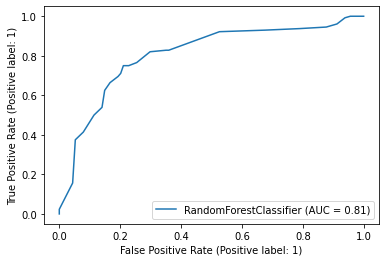

In [517]:
rf_classifier_disp = plot_roc_curve(rf_classifier, trainX, trainY)
plt.show()

### ROC curve for test set

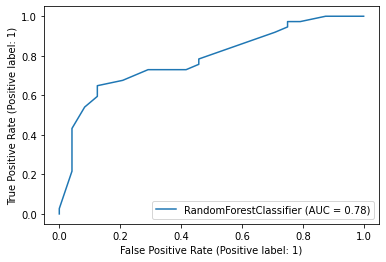

In [518]:
rf_classifier_disp = plot_roc_curve(rf_classifier, testX, testY)
plt.show()

# Train SGD Classifier   

In [519]:
sgd_classifier = SGDClassifier(max_iter=1000, tol=1e-3, 
                        random_state=42).fit(trainX, trainY) 

sgd_2 = SGDClassifier(max_iter=1000, tol=1e-3, 
                        random_state=42).fit(SGDX, trainY)

## Test using crossval score and maybe still round or present as percent

In [520]:
# Score using 5-fold cv on classifier trained on unscaled data
score5 = cross_val_score(sgd_classifier, trainX, trainY, cv=5, scoring='accuracy')
score6 = cross_val_score(sgd_classifier, testX, testY, cv=5, scoring='accuracy')

# Score using 5-fold cv on classifier trained on scaled data
score5b = cross_val_score(sgd_2, SGDX, trainY, cv=5, scoring='accuracy')
score6b = cross_val_score(sgd_2, SGDX_t, testY, cv=5, scoring='accuracy')

# Collect means of cv accuracy scores for display
sgd_means = []
sgd_means.append(np.mean(score5))
sgd_means.append(np.mean(score6))
sgd_means.append(np.mean(score5b))
sgd_means.append(np.mean(score6b))

# Create dataFrames to display scores
sgd_scores = pd.DataFrame({ 'Training score' : score5 , 'Test score' : score6, 'Training score (scaled)' : score5b , 'Test score (scaled)' : score6b})
sgd_mean = pd.DataFrame({ 'Training mean' : [sgd_means[0]] , 'Test mean' : [sgd_means[1]], 'Training mean (scaled)' : [sgd_means[2]] , 'Test mean (scaled)' : [sgd_means[3]]})

In [521]:
sgd_scores

,Training score,Test score,Training score (scaled),Test score (scaled)
0,0.612245,0.538462,0.775510,0.692308
1,0.775510,0.666667,0.816327,0.916667
2,0.708333,0.583333,0.791667,0.916667
3,0.583333,0.583333,0.791667,0.500000
4,0.520833,0.666667,0.854167,0.583333


In [522]:
sgd_mean

,Training mean,Test mean,Training mean (scaled),Test mean (scaled)
0,0.640051,0.607692,0.805867,0.721795


## Confusion matrix and ROC curve

In [523]:
# Get predictions using cross_val_predict
sgd_prd = cross_val_predict(sgd_classifier, testX, testY, cv=10)
sgd_prd2 = cross_val_predict(sgd_classifier, SGDX_t, testY, cv=10)
labels = sgd_classifier.classes_

# compute TP, TN, FP, FN values for each classifier
sgd_cm = confusion_matrix(y_true=testY, y_pred = sgd_prd, labels = labels)
sgd_cr = classification_report(y_true=testY, y_pred = sgd_prd, labels = labels)

# compute recall, precision, f1-scores for each classifier
sgd2_cm = confusion_matrix(y_true=testY, y_pred = sgd_prd2, labels = labels)
sgd2_cr = classification_report(y_true=testY, y_pred = sgd_prd2, labels = labels)

#### Confusion matrix for classifier trained on unscaled data

In [524]:
# print confusion matrix
pd.DataFrame(sgd_cm, index=labels, columns=labels)

,0,1
0,10,14
1,9,28


#### Classification report for classifier trained on unscaled data

In [525]:
print(sgd_cr)

              precision    recall  f1-score   support

           0       0.53      0.42      0.47        24
           1       0.67      0.76      0.71        37

    accuracy                           0.62        61
   macro avg       0.60      0.59      0.59        61
weighted avg       0.61      0.62      0.61        61



#### Confusion matrix for classifier trained on scaled data

In [526]:
pd.DataFrame(sgd2_cm, index=labels, columns=labels)

,0,1
0,15,9
1,6,31


#### Classification report for classifier trained on scaled data

In [527]:
print(sgd2_cr)

              precision    recall  f1-score   support

           0       0.71      0.62      0.67        24
           1       0.78      0.84      0.81        37

    accuracy                           0.75        61
   macro avg       0.74      0.73      0.74        61
weighted avg       0.75      0.75      0.75        61



### ROC curve for training set

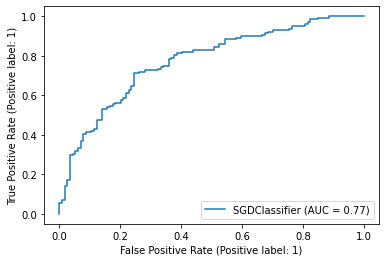

In [528]:
sgd_classifier_disp = plot_roc_curve(sgd_classifier, trainX, trainY)
plt.show()

### ROC curve for test set

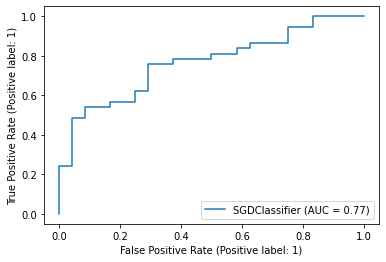

In [529]:
sgd_classifier_disp = plot_roc_curve(sgd_classifier, testX, testY)
plt.show()

# 6. Plot the obtained training and testing accuracies for all 3 models in one graph 

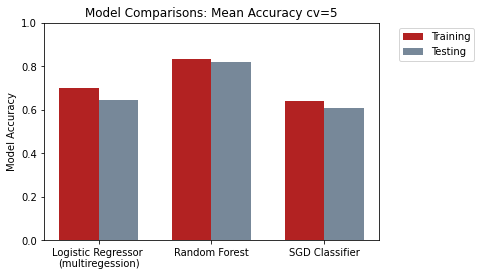

In [530]:
labels = ['Logistic Regressor \n(multiregession)', 'Random Forest', 'SGD Classifier']
training_scores = [lr_means[0], rf_means[0], sgd_means[0]]
testing_scores =  [lr_means[1], rf_means[1], sgd_means[1]]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, training_scores, width, label='Training', color='firebrick')
rects2 = ax.bar(x + width/2, testing_scores, width, label='Testing', color='lightslategray')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Model Accuracy')
ax.set_xticks(x)
ax.set_ylim(0,1)
ax.set_xticklabels(labels)
ax.legend(bbox_to_anchor = (1.3, 1.0), loc='upper right')

plt.title('Model Comparisons: Mean Accuracy cv=5')
plt.show()

# 7. Verify whether or not scaling the data helps improve model accuracies.

### The confusion matrices for each model in this notebook have shown improvement from the model trained on unscaled data to the model trained onthe scaled data, except for the regression forest, which was unaffected.  

### The first graph below shows the accuracy scores as above but for the models trained on scaled data.  The second graph shows all 6 models, both models of each type plotted next to each other to make the improvement with scaling clearer.

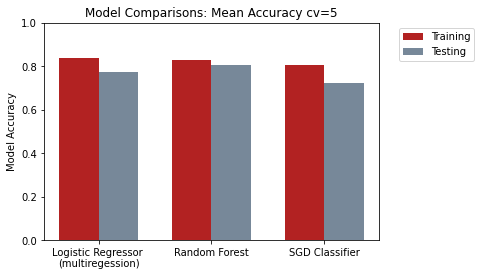

In [531]:
labels = ['Logistic Regressor \n(multiregession)', 'Random Forest', 'SGD Classifier']
training_scores = [lr_means[2], rf_means[2], sgd_means[2]]
testing_scores =  [lr_means[3], rf_means[3], sgd_means[3]]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, training_scores, width, label='Training', color='firebrick')
rects2 = ax.bar(x + width/2, testing_scores, width, label='Testing', color='lightslategray')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Model Accuracy')
ax.set_xticks(x)
ax.set_ylim(0,1)
ax.set_xticklabels(labels)
ax.legend(bbox_to_anchor = (1.3, 1.0), loc='upper right')

plt.title('Model Comparisons: Mean Accuracy cv=5')
plt.show()

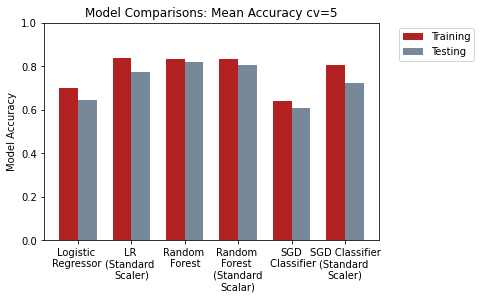

In [532]:
labels = ['Logistic \nRegressor \n', 'LR \n(Standard \nScaler)',  'Random \nForest', 'Random \nForest \n (Standard \nScalar)', 'SGD\n Classifier', 'SGD Classifier\n(Standard \nScaler)']
training_scores = [lr_means[0], lr_means[2], rf_means[0], rf_means[2], sgd_means[0], sgd_means[2]]
testing_scores =  [lr_means[1], lr_means[3], rf_means[1], rf_means[3], sgd_means[1], sgd_means[3]]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, training_scores, width, label='Training', color='firebrick')
rects2 = ax.bar(x + width/2, testing_scores, width, label='Testing', color='lightslategrey')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Model Accuracy')
ax.set_xticks(x)
ax.set_ylim(0,1)
ax.set_xticklabels(labels)
ax.legend(bbox_to_anchor = (1.3, 1.0), loc='upper right')

plt.title('Model Comparisons: Mean Accuracy cv=5')
plt.show()

# 8. Summary of Findings

### The most consistent model was the Random Forest, which was the best model before and after scaling.  Scaling the data led to serious improvement in the performance of the LR and SGD classifiers but left the Random Forest classifier's performance unchanged.  The logistic regression classifier moderately outperformed the SGD before and after scaling.  The best performing model, the Random Forest Regressor, had accuracy of 84%.

### A problem I had at first was that the test accuracy was higher than the training accuracy.  After some searching online I came to the conclusion that the small size of the dataset made it prone to the problem of sampling bias.  For the 80-20 splits, there were only 61 instances in the test set!  That made it more likely that  the distributions of the splits could be responsible for strange results.  For the submission I found splits that did not do better on the test set than the training set.  